 Les Biblios

In [138]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# 1. Modèle Conditional VAE

In [139]:
class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, n_classes=2):
        super().__init__()
        
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + n_classes, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y_onehot):
        x_cond = torch.cat([x, y_onehot], dim=1)
        h = self.encoder(x_cond)
        mu, logvar = self.mu(h), self.logvar(h)
        z = self.reparameterize(mu, logvar)
        z_cond = torch.cat([z, y_onehot], dim=1)
        return self.decoder(z_cond), mu, logvar


# 2. Fonction de perte

In [140]:
def cvae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl


# 3. Entraînement du cVAE

In [141]:
def train_cvae(X, y, latent_dim=10, epochs=50, batch_size=128):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # 🔑 conversion explicite
    X_np = X.values if hasattr(X, "values") else X
    y_np = y.values if hasattr(y, "values") else y

    X_t = torch.tensor(X_np, dtype=torch.float32)
    y_t = torch.tensor(y_np, dtype=torch.long)

    y_oh = torch.nn.functional.one_hot(y_t, num_classes=2).float()

    dataset = TensorDataset(X_t, y_oh)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = CVAE(X_t.shape[1], latent_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            recon, mu, logvar = model(xb, yb)
            loss = cvae_loss(recon, xb, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")

    return model


# 4. Génération d’échantillons synthétiques (classe minoritaire)

In [142]:
def generate_synthetic_samples(model, n_samples, target_class, latent_dim):
    device = next(model.parameters()).device

    z = torch.randn(n_samples, latent_dim).to(device)
    y = torch.full((n_samples,), target_class, dtype=torch.long).to(device)
    y_oh = torch.nn.functional.one_hot(y, num_classes=2).float()

    z_cond = torch.cat([z, y_oh], dim=1)
    synthetic_X = model.decoder(z_cond).detach().cpu().numpy()
    
    synthetic_y = np.full(n_samples, target_class)
    return synthetic_X, synthetic_y


# 5. Fonction principale : équilibrage de la base

In [143]:
def balance_dataset_with_cvae(X, y, latent_dim=10):
    # Comptage des classes
    unique, counts = np.unique(y, return_counts=True)
    class_counts = dict(zip(unique, counts))

    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)

    n_to_generate = class_counts[majority_class] - class_counts[minority_class]

    print(f"Classe minoritaire : {minority_class}")
    print(f"Échantillons à générer : {n_to_generate}")

    # Entraînement
    model = train_cvae(X, y, latent_dim=latent_dim)

    # Génération
    X_syn, y_syn = generate_synthetic_samples(
        model, n_to_generate, minority_class, latent_dim
    )

    # Dataset équilibré
    X_balanced = np.vstack([X, X_syn])
    y_balanced = np.hstack([y, y_syn])

    return X_balanced, y_balanced


In [144]:
import pandas as pd
from joblib import load
from preprocessor import *
from sklearn.model_selection import train_test_split

## Masquage des labels

In [145]:
# Chargement des donnees
data = pd.read_csv('/home/onyxia/PROJET_STATAPP/Data/Cleans/Data_for_active_learning.csv')
data.head(2)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,FraudFound_P,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,0,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,0,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61


In [146]:
# Chargement des donnees non labelisees et des labels
no_labels_data = data.drop(columns=['FraudFound_P'])
labels = data['FraudFound_P']
no_labels_data.head(3)

,Unnamed: 0,Make,AccidentArea,Sex,MaritalStatus,Age,Fault,PolicyType,VehiclePrice,Deductible,...,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,delay_weeks
0,0,Honda,Urban,Female,Single,21,Policy Holder,Sport - Liability,more than 69000,300,...,more than 30,none,3 years,No,No,External,none,1 year,3 to 4,1
1,1,Honda,Urban,Male,Single,34,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,none,6 years,Yes,No,External,none,no change,1 vehicle,61
2,2,Honda,Urban,Male,Married,47,Policy Holder,Sport - Collision,more than 69000,400,...,more than 30,1,7 years,No,No,External,none,no change,1 vehicle,2


In [147]:
# Chargement du pipeline
preprocessor = load("preprocessor.joblib")

In [148]:
all_cols = binary_cols + label_cols + freq_cols + ordinal_cols + scale_cols # definit dans preprocessor.py
no_labels_data_preprocessed = preprocessor.fit_transform(no_labels_data)
no_labels_data_preprocessed = pd.DataFrame(no_labels_data_preprocessed, columns=all_cols)
no_labels_data_preprocessed.head(2)

,AccidentArea,Sex,Fault,PoliceReportFiled,WitnessPresent,AgentType,Make,MaritalStatus,PolicyType,VehiclePrice,Days_Policy_Accident,PastNumberOfClaims,AgeOfVehicle,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,DriverRating,Deductible,Age,delay_weeks
0,1.0,0.0,1.0,0.0,0.0,0.0,6.0,2.0,0.000065,5.0,4.0,0.0,2.0,0.0,2.0,2.0,1.0,300.0,-1.516574,-1.856357
1,1.0,1.0,1.0,1.0,0.0,0.0,6.0,2.0,0.022570,5.0,4.0,0.0,5.0,0.0,0.0,0.0,4.0,400.0,-0.489689,0.602140


## Separation des donnees

In [149]:
X_seed, X_pool, y_seed, y_pool = train_test_split(no_labels_data_preprocessed, labels, train_size=200, stratify=labels, random_state=42)

In [150]:
## Entrainement preliminaire du modele

In [151]:
# Chargement du modele
lightgbm_model = load('/home/onyxia/PROJET_STATAPP/Notebooks/lgbm_untrained.joblib')

In [152]:
# fit du modele
lightgbm_model.fit(X_seed, y_seed)

[LightGBM] [Info] Number of positive: 12, number of negative: 188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 200, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.060000 -> initscore=-2.751535
[LightGBM] [Info] Start training from score -2.751535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.05
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Implementation de l'active learning

In [153]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(
    learning_rate=0.05,
    max_depth=10,
    n_estimators=300,
    random_state=42
)

In [154]:
import pandas as pd
import numpy as np

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    roc_curve
)


# -----------------------
# Tracking des résultats
# -----------------------
results = []

# -----------------------
# Boucle d'active learning
# -----------------------
i = 0
while len(X_seed) < 11000 and i<11:

    # ---- 1. CVAE ----
    X_seed_CVAE, y_seed_CVAE = balance_dataset_with_cvae(X_seed, y_seed)

    # ---- 2. Entraînement ----
    model.fit(X_seed_CVAE, y_seed_CVAE)

    # ---- 3. Évaluation sur le pool (sans SMOTE) ----
    y_pred = model.predict(X_pool)
    y_proba = model.predict_proba(X_pool)[:, 1]

    results.append({
        "labels_used": len(X_seed),
        "accuracy": accuracy_score(y_pool, y_pred),
        "f1": f1_score(y_pool, y_pred),
        "recall": recall_score(y_pool, y_pred),
        "precision": precision_score(y_pool, y_pred),
        "auc": roc_auc_score(y_pool, y_proba)
    })

    # ---- 4. Calcul de l'indice de Youden ----
    fpr, tpr, thresholds = roc_curve(y_pool, y_proba)
    youden = tpr - fpr
    best_idx = np.argmax(youden)
    youden_threshold = thresholds[best_idx]

    # Intervalle adaptatif de largeur ~0.95
    half_width = 0.95 / 2
    lower = max(0.01, youden_threshold - half_width)
    upper = min(0.99, youden_threshold + half_width)

    # ---- 5. Uncertainty sampling ----
    uncertain_mask = (y_proba > lower) & (y_proba < upper)
    uncertain_indices = X_pool.loc[uncertain_mask].index

    # Sécurité : aucun point incertain
    if len(uncertain_indices) == 0:
        print("Aucun point incertain → arrêt.")
        break

    # ---- 6. Ajout des points sélectionnés (données réelles) ----
    X_new = X_pool.loc[uncertain_indices]
    y_new = y_pool.loc[uncertain_indices]

    X_seed = pd.concat([X_seed, X_new])
    y_seed = pd.concat([y_seed, y_new])

    # ---- 7. Suppression du pool ----
    X_pool = X_pool.drop(uncertain_indices)
    y_pool = y_pool.drop(uncertain_indices)
    i = i + 1
    print(
        f"Iteration: {len(results)} | "
        f"Nouveaux labels: {len(uncertain_indices)} | "
        f"Total labels: {len(X_seed)} | "
        f"Youden threshold: {youden_threshold:.3f}"
    )

# -----------------------
# Résultats finaux
# -----------------------
results_df = pd.DataFrame(results)
results_df

Classe minoritaire : 1
Échantillons à générer : 176


Epoch 10/50 - Loss: 17147.0156
Epoch 20/50 - Loss: 14932.9575
Epoch 30/50 - Loss: 4441.2998
Epoch 40/50 - Loss: 2096.7227
Epoch 50/50 - Loss: 1177.7665
[LightGBM] [Info] Number of positive: 188, number of negative: 188
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 376, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

,labels_used,accuracy,f1,recall,precision,auc
0,200,0.921217,0.086824,0.062569,0.141791,0.663802
1,1909,0.944856,0.083641,0.047820,0.333333,0.769990
2,5730,0.972649,0.147910,0.084871,0.575000,0.864421
3,7916,0.991070,0.385321,0.280000,0.617647,0.860054
4,8299,0.993539,0.465116,0.363636,0.645161,0.834240
5,8467,0.993815,0.481928,0.377358,0.666667,0.867179
6,8520,0.994492,0.512821,0.392157,0.740741,0.849817
7,8719,0.994478,0.519481,0.400000,0.740741,0.856934
8,8773,0.994433,0.506667,0.380000,0.760000,0.872048
9,8806,0.994859,0.540541,0.416667,0.769231,0.867490


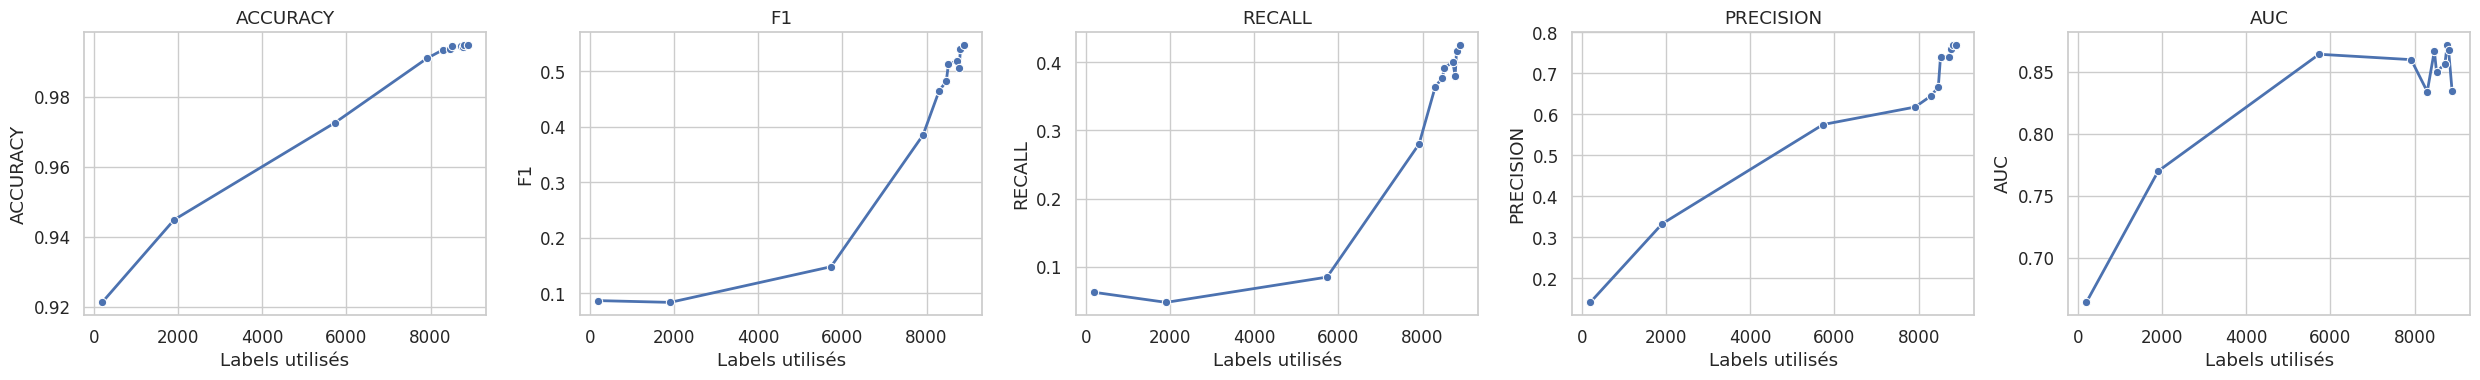

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Style seaborn
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

metrics = ["accuracy", "f1", "recall", "precision", "auc"]
n_metrics = len(metrics)

# Déterminer nombre de colonnes pour 2 lignes
n_rows = 1
n_cols = math.ceil(n_metrics / n_rows)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=True)

# Aplatir axes si nécessaire
axes = axes.flatten()

for i, m in enumerate(metrics):
    ax = axes[i]
    sns.lineplot(
        x=results_df["labels_used"],
        y=results_df[m],
        marker="o",
        linewidth=2,
        ax=ax
    )
    ax.set_title(m.upper())
    ax.set_xlabel("Labels utilisés")
    ax.set_ylabel(m.upper())

# Supprimer les axes vides si n_metrics < n_rows * n_cols
for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
